# Text Study

After the initial audio study and the necessary text extraction, the next logical step will be the stduy of this type of unstructured data.

We will take a look at both the audio transcripts and the captions from the videos, in order to extract as much information as possible to predict the virality of a video.

## First libraries and variables import

In [1]:
import sys
from pathlib import Path
import os
import ast
import numpy as np

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import os
sns.set()

# Get the absolute path of the folder containing the module
root_dir = Path.cwd().resolve().parent.parent

# Add the folder path to sys.path
sys.path.append(str(root_dir))

import nltk
from nltk.tokenize import word_tokenize
from InstructorEmbedding import INSTRUCTOR
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from mltools import regression_tools as RT
from mltools import model_tools as MT

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\InstructorEmbedding\instructor.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


In [2]:
from text_utils import load_json, load_transcriptions, clean_text, plot_freq_dist, analyze_text, get_bag_of_words, perform_topic_modeling, \
                        classify_sentiment, count_sentiments, concatenate_embeddings, calculate_metrics
from config.variables import text_path, json_file, csv_file, textcsv_file

In [3]:
text_folder = os.path.join(root_dir, text_path)
json_path = os.path.join(root_dir, json_file)

## Data recopilation and ordering

In [4]:
# Load the transcriptions of the videos
transcriptions = load_transcriptions(text_folder)

# Load the information from the JSON file
video_info = load_json(json_path)

In [5]:
# Create an object to store the combined information
video_data = {}

# Combine the information from transcriptions and the JSON file
for video_id, info in video_info.items():
    if video_id in transcriptions:
        general = info.get('general', '')  # Get the general information of the video or an empty string if not present
        text = general.get('text', '')  # Get the text of the video or an empty string if not present
        hashtags = general.get('hashtags', [])  # Get the hashtags of the video or an empty list if not present
        video_data[video_id] = {'transcription': transcriptions[video_id], 'text': text, 'hashtags': hashtags}

# Example of accessing the combined information for the first video
first_video = list(video_data.keys())[0]
print("Transcription:", video_data[first_video]['transcription'])
print("Text:", video_data[first_video]['text'])
print("Hashtags:", video_data[first_video]['hashtags'])

Transcription: 
Text: Confidence went 📈
Hashtags: []


In [6]:
# Counting the elements that are not empty strings in transcriptions
transcription_count = sum(1 for trans in transcriptions.values() if trans != '')
print("Number of non-empty transcriptions:", transcription_count)

# Counting the number of elements in video_data where the transcription is not ''
video_data_count_non_empty = sum(1 for video_id, data in video_data.items() if data['transcription'] != '')
print("Number of video_data elements with non-empty transcriptions:", video_data_count_non_empty)

# Counting the elements that are not empty strings in the video text
texts_count = sum(1 for video_id, data in video_data.items() if data['text'] != '')
print("Number of video_data elements with non-empty text:", texts_count)

# Counting the elements that are not empty lists in hashtags
hashtags_count = sum(1 for video_id, data in video_data.items() if data['hashtags'] != [])
print("Number of video_data elements with non-empty hashtags:", hashtags_count)


Number of non-empty transcriptions: 261
Number of video_data elements with non-empty transcriptions: 261
Number of video_data elements with non-empty text: 962
Number of video_data elements with non-empty hashtags: 853


As we can see, we have a transcription for 1 out of 4 videos aprox. Nevertheless, we have text and hashtags for almost all of the videos, so a text strudy could be deployed.

## Text Pre-Processing

### Text cleaning

In [7]:
# text cleaning of transcriptions and text
for video_id, data in video_data.items():
    if 'transcription' in data:
        video_data[video_id]['clean_transcription'] = clean_text(data['transcription'])
    if 'text' in data:
        video_data[video_id]['clean_text'] = clean_text(data['text'])

In [8]:
video_data[list(video_data.keys())[34]]

{'transcription': "is there the top 10 strongest one piece characters by the end of the show at number 10 we have Trafalgar law he can make anyone Immortal at the expense of his life number 9 we have useless kid he challenged kaido even though the odds are against him just like Luffy number 8 we have Sabo even though he's not at his Peak he can challenge fujitora and number 7 we have GARP the only man known to go to Toe with the former pirate king Goldie Rodger number 6 we have a kind of the author himself Oda said that if a kind of was the main character he'd find the one piece in a single year number five we have Shanks at the marineford where he just came in and said war is over and it really ended what else do you need to know about Shanks make sure like for part two",
 'text': '#Top10 Strongest #onepiece Characters by the end of the show. #anime #strongestcharacters #animeboy #luffy #zoro #animeedit #animeedits #animestiktok',
 'hashtags': ['top10',
  'onepiece',
  'anime',
  'str

As we can see, it has occured a tokenization, lemmatization and an elimination of hashtags, punctuation signs, special characters and stopwords for both text and transcription, bearing in mind the language of the possible text and transcription.

### Exploratory analysis

The next step will be the frequency distribution and the word cloud of the clean transcripts and texts, as well as the hashtags (probably the most useful one).

In [9]:
video_data

{'6907228749016714497': {'transcription': '',
  'text': 'Confidence went 📈',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': 'confidence went'},
 '6875468410612993286': {'transcription': '',
  'text': 'Quiet Zone... follow me on insta: joeysofo. Comment where you wanna see me blade next. Reply to @dwight_schnuute',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': 'quiet zone follow insta joeysofo comment wan na see blade next reply'},
 '6898699405898059010': {'transcription': '',
  'text': 'Iphone bend test🤗 #tiktok #viral #fyp #iphone #test #bend',
  'hashtags': ['tiktok', 'viral', 'fyp', 'iphone', 'test', 'bend'],
  'clean_transcription': '',
  'clean_text': 'iphone bend'},
 '6902819837345533186': {'transcription': '',
  'text': '',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': ''},
 '6905635666588192002': {'transcription': '',
  'text': '小技です👟✨#tiktok教室#tutorial',
  'hashtags': ['tiktok教室', 'tutorial'],
  'clean_transcription': '',
  'cl

In [10]:
# Collect clean transcripts, clean texts, and hashtags from video_info
clean_transcripts = []
clean_texts = []
hashtags = []
for info in video_data.values():
    if 'clean_transcription' in info:
        clean_transcripts.extend(word_tokenize(info['clean_transcription']))
    if 'clean_text' in info:
        clean_texts.extend(word_tokenize(info['clean_text']))
    if 'hashtags' in info:
        hashtags.extend(info['hashtags'])

Analysis of Transcripts:
<FreqDist with 2011 samples and 5249 outcomes>


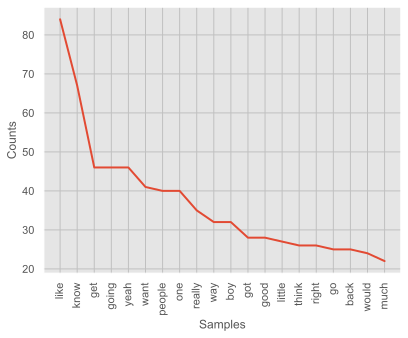

Most common words: [('like', 84), ('know', 67), ('get', 46), ('going', 46), ('yeah', 46), ('want', 41), ('people', 40), ('one', 40), ('really', 35), ('way', 32)]


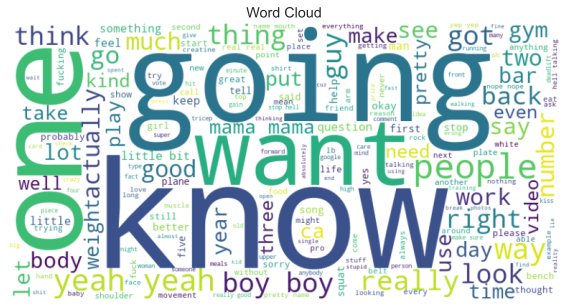

In [13]:
# Plot frequency distribution and word cloud for clean transcripts
print("Analysis of Transcripts:")
plot_freq_dist(clean_transcripts)
analyze_text(' '.join(clean_transcripts))

Analysis of Captions:
<FreqDist with 1958 samples and 2856 outcomes>


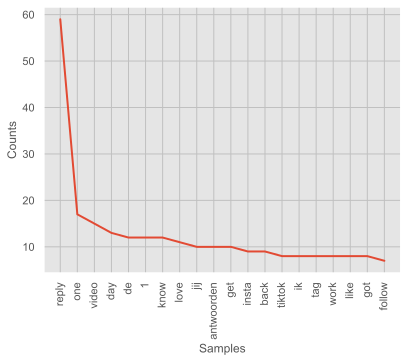

Most common words: [('reply', 59), ('one', 17), ('video', 15), ('day', 13), ('de', 12), ('1', 12), ('know', 12), ('love', 11), ('jij', 10), ('antwoorden', 10)]


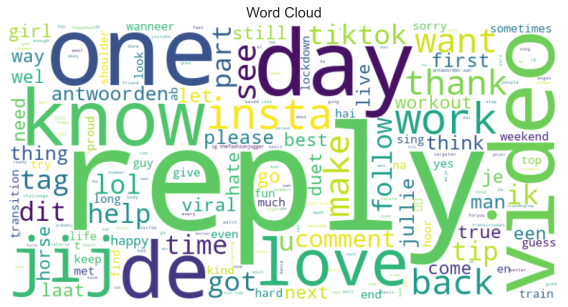

In [14]:
# Plot frequency distribution and word cloud for clean texts
print("Analysis of Captions:")
plot_freq_dist(clean_texts)
analyze_text(' '.join(clean_texts))

Analysis of Hashtags:
<FreqDist with 2220 samples and 5330 outcomes>


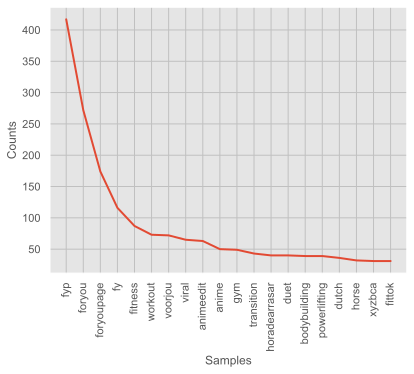

Most common words: [('fyp', 417), ('foryou', 272), ('foryoupage', 174), ('fy', 116), ('fitness', 87), ('workout', 73), ('voorjou', 72), ('viral', 65), ('animeedit', 63), ('anime', 50)]


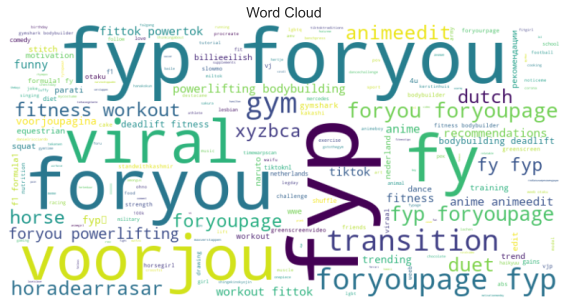

In [15]:
# Plot frequency distribution and word cloud for hashtags
print("Analysis of Hashtags:")
plot_freq_dist(hashtags)
analyze_text(' '.join(hashtags))

As we can see, it does not seem that a clear keyword is used in the transcripts or captions. Nevertheless, most tiktok videos has the hashtag ``fyp``, ``foryou``, ``foryoupage``, maybe in order to be recommended to users with similar interests. Furthermore, the most used ones are related with the exercise and anime.

Other techniques such as tf idf, post tagging, NER, topic modelling, etc. do not seem to have a clear usefulness for this use case. Likewise, an example is made to indicate its operation.

In [16]:
# Example usage with clean transcripts and clean texts
sentences = clean_transcripts + clean_texts
get_bag_of_words(sentences)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
{'let': 1665, 'place': 2178, 'getting': 1194, 'lot': 1731, 'people': 2146, 'asking': 241, 'recommending': 2385, 'use': 3077, 'sirens': 2615, 'security': 2531, 'guards': 1265, 'comments': 628, 'wanted': 3180, 'touch': 2979, 'also': 166, 'known': 1591, 'selective': 2541, 'androgenic': 189, 'receptor': 2380, 'modulators': 1899, 'held': 1329, 'next': 1991, 'generation': 1183, 'anabolic': 186, 'steroids': 2747, 'yielding': 3290, 'similar': 2606, 'results': 2433, 'without': 3249, 'side': 2601, 'effects': 909, 'true': 3022, 'starters': 2732, 'essentially': 969, 'completely': 641, 'unregulated': 3067, 'industry': 1446, 'according': 91, 'dr': 855, 'bill': 375, 'lewellen': 1673, 'likely': 1691, 'get': 1191, 'paid': 2106, 'said': 2489, 'chance': 547, 'rest': 2431, 'know': 1588, 'much': 1933, 'nobody': 2009, 'regardless': 2392, 'anybody': 207, 'might': 1860, 'tell': 2880, 'minima

In [17]:
# Example usage
topics_per_video = perform_topic_modeling(video_data)
for video_id, topics in topics_per_video.items():
    print("Topics for video", video_id)
    print(topics)

Topics for video 6907228749016714497
[(0, '1.000*"confidence went"'), (1, '1.000*"confidence went"')]
Topics for video 6875468410612993286
[(0, '1.000*"quiet zone follow insta joeysofo comment wan na see blade next reply"'), (1, '1.000*"quiet zone follow insta joeysofo comment wan na see blade next reply"')]
Topics for video 6898699405898059010
[(0, '0.143*"iphone" + 0.143*"iphone bend"'), (1, '0.143*"tiktok" + 0.143*"viral"')]
Topics for video 6902819837345533186
No cleaned data available
Topics for video 6905635666588192002
[(0, '0.500*"tiktok教室" + 0.500*"tutorial"'), (1, '0.500*"tutorial" + 0.500*"tiktok教室"')]
Topics for video 6895497835681287426
[(0, '0.250*"great rally show love comments" + 0.250*"volleyballlove"'), (1, '0.250*"volleyballworld" + 0.250*"volleyball"')]
Topics for video 6895303013867539713
[(0, '1.000*"oh"'), (1, '1.000*"oh"')]
Topics for video 6884590643327290625
[(0, '1.000*"timewarpscan"'), (1, '1.000*"timewarpscan"')]
Topics for video 6906514963569888513
[(0, '0

It is easily observable that no large conclusions can be drawn from these exploratory and feature extraction methods. This is due to the short and incomprehensible texts of the videos and transcripts without the rest of the information.

We already knew that text was our weakest source of information, and from which we could possibly extract the least information.

### Sentiment analysis

Now, the final step of data exploration and feature extraction focuses on a basic sentiment analysis. The goal is to extract more information from the videos in order to create more accurate models, or even to consider the possibility of using models that do not rely on text, but only on hashtags and sentiments to predict their virality. Both models will be tested to observe which ones obtain more accurate results for our training and validation sets, which will be divided in the next step.

In [18]:
classify_sentiment(video_data)

In [19]:
video_data

{'6907228749016714497': {'transcription': '',
  'text': 'Confidence went 📈',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': 'confidence went',
  'text_sentiment': 'Positive',
  'transcript_sentiment': 'Unknown'},
 '6875468410612993286': {'transcription': '',
  'text': 'Quiet Zone... follow me on insta: joeysofo. Comment where you wanna see me blade next. Reply to @dwight_schnuute',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': 'quiet zone follow insta joeysofo comment wan na see blade next reply',
  'text_sentiment': 'Negative',
  'transcript_sentiment': 'Unknown'},
 '6898699405898059010': {'transcription': '',
  'text': 'Iphone bend test🤗 #tiktok #viral #fyp #iphone #test #bend',
  'hashtags': ['tiktok', 'viral', 'fyp', 'iphone', 'test', 'bend'],
  'clean_transcription': '',
  'clean_text': 'iphone bend',
  'text_sentiment': 'Neutral',
  'transcript_sentiment': 'Unknown'},
 '6902819837345533186': {'transcription': '',
  'text': '',
  'hashtags': [],
  

In [20]:
# Count the sentiments of the videos
count_sentiments(video_data)

Sentiment Counts for Text and Transcriptions (BLOB):

Sentiment  Text       Transcription
Positive   139        109       
Negative   63         45        
Neutral    798        846       
Unknown    0          0         


Sentiment Counts for Text and Transcriptions (VADER):

Sentiment  Text       Transcription
Positive   152        132       
Negative   62         50        
Neutral    786        818       
Unknown    0          0         


Sentiment Counts for Text and Transcriptions (BOTH):

Sentiment  Text       Transcription
Positive   202        137       
Negative   87         60        
Neutral    673        64        
Unknown    38         739       




As can be seen, most videos are either unlabeled or neutral, especially when looking at the transcriptions, although there appear to be more videos classified as positive sentiment than negative. Additionally, the hybrid method seems to be more effective, using both TextBlob and VADER for sentiment analysis and producing a combined response.

Finally, it's normal for the sentiments of a video's transcription and caption to differ, as captions may consist solely of hashtags or may indicate a response, among other possibilities.

### Embedding creation

The next and last step before the model creation will be the train/test split, the addition of out virality response variable, created, explained and stored in the ``project.ipynb`` and the embedding creation.

In [21]:
csv_path = os.path.join(root_dir, csv_file)

df_virality = pd.read_csv(csv_path)

data = []

for video_id, info in video_data.items():
    virality_info = df_virality[df_virality['id'] == int(video_id)]
    if not virality_info.empty:
        combined_info = {
            'video_id': video_id,
            'hashtags': info['hashtags'],
            'norm_virality': virality_info['norm_virality'].values[0]  # Add norm_virality from the DataFrame
        }
        if info['transcription']:
            combined_info['clean_transcription'] = info['clean_transcription']
            combined_info['transcript_sentiment'] = info['transcript_sentiment']
        else:
            combined_info['clean_transcription'] = ''
            combined_info['transcript_sentiment'] = ''
        if info['text']:
            combined_info['clean_text'] = info['clean_text']
            combined_info['text_sentiment'] = info['text_sentiment']
        else:
            combined_info['clean_text'] = ''
            combined_info['text_sentiment'] = ''
        data.append(combined_info) if int(video_id) in df_virality['id'].values else print(f"Video {video_id} not in virality data")
        
df = pd.DataFrame(data)

df

,video_id,hashtags,norm_virality,clean_transcription,transcript_sentiment,clean_text,text_sentiment
0,6907228749016714497,[],0.000177,,,confidence went,Positive
1,6875468410612993286,[],0.003337,,,quiet zone follow insta joeysofo comment wan n...,Negative
2,6898699405898059010,"[tiktok, viral, fyp, iphone, test, bend]",0.060929,,,iphone bend,Neutral
3,6902819837345533186,[],0.000377,,,,
4,6905635666588192002,"[tiktok教室, tutorial]",0.000457,,,,Neutral
...,...,...,...,...,...,...,...
995,6877191692341054721,"[foryou, foryoupage]",0.000513,hi please scroll seen video means small creato...,Negative,,Neutral
996,6908069845825359109,"[gttfg, gotothegym, swolefam, nutrition, diet,...",0.000320,fuck pumpkin spice stop shoveling garbage mout...,Negative,stop eating,Negative
997,6883484287434378497,"[fy, foryoupage, foryou]",0.001790,,,,Neutral
998,6898721943978036481,"[fyp, foryou, curls]",0.000286,imagine long beautiful hair one day wake think...,Positive,regretss,Neutral


Prior to the model creation, an embedding model is used to transform the clean text, transcript and hashtags. It could also be investigated with different embedding models, but it is not the objective of this work, so a HuggingFace model with good general results is chosen.

In [22]:
# # First execution may be long due to the model download

# model = INSTRUCTOR('hkunlp/instructor-xl')
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
# # Text embedding creation 
# embeddings = model.encode(sentences=df['clean_text'].values, show_progress_bar=True, device=device, normalize_embeddings=True)

In [24]:
# # Text embedding storage
# df['text_embedding'] = embeddings.tolist()

In [25]:
# # Transcription embedding creation & storage
# embeddings = model.encode(sentences=df['clean_transcription'].values, show_progress_bar=True, device=device, normalize_embeddings=True)
# df['transcription_embedding'] = embeddings.tolist()

In [26]:
# df

In [27]:
# df.to_csv(os.path.join(root_dir, textcsv_file, 'embeddings.csv'), index=False)

In [28]:
df = pd.read_csv(os.path.join(root_dir, textcsv_file, 'embeddings.csv'))
df['hashtags'] = df['hashtags'].apply(ast.literal_eval)

In [29]:
# Tokenize hashtags into lists of words
tokenized_hashtags = [hashtag.split() for hashtag in hashtags]

In [30]:
# Find the maximum number of hashtags in any video
max_hashtags = max(df['hashtags'].apply(len))

# Create new columns for each hashtag
for i in range(1, max_hashtags + 1):
    df[f'hashtag_{i}'] = ''

# Populate the new columns with hashtags
for index, hashtags in enumerate(df['hashtags']):
    for i, hashtag in enumerate(hashtags):
        if i < max_hashtags:
            df.at[index, f'hashtag_{i+1}'] = hashtag

In [31]:
for feature in ['transcription_embedding', 'text_embedding']:
    df[feature] = df[feature].apply(ast.literal_eval)

In [32]:
for i in range(1, max_hashtags + 1):
    df[f'hashtag_{i}'] = df[f'hashtag_{i}'].astype(str)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_id                 1000 non-null   int64  
 1   hashtags                 1000 non-null   object 
 2   norm_virality            1000 non-null   float64
 3   clean_transcription      256 non-null    object 
 4   transcript_sentiment     261 non-null    object 
 5   clean_text               758 non-null    object 
 6   text_sentiment           962 non-null    object 
 7   text_embedding           1000 non-null   object 
 8   transcription_embedding  1000 non-null   object 
 9   hashtag_embeddings       1000 non-null   object 
 10  hashtag_1                1000 non-null   object 
 11  hashtag_2                1000 non-null   object 
 12  hashtag_3                1000 non-null   object 
 13  hashtag_4                1000 non-null   object 
 14  hashtag_5                

In [34]:
# Train Word2Vec model for hashtags
hashtag_model = Word2Vec(sentences=tokenized_hashtags, vector_size=50, window=5, min_count=1, workers=8, seed=42)

# Apply the function to create embeddings for each row in the DataFrame
for i in range(1, max_hashtags + 1):
    df[f"hashtag_embedding_{i}"] = df[f"hashtag_{i}"].apply(lambda hashtag: hashtag_model.wv[hashtag] if hashtag in hashtag_model.wv else np.zeros(50))

In [35]:
df_clean = df.drop(columns=['hashtags', 'clean_transcription', 'clean_text', 'transcript_sentiment', 'text_sentiment'])

for i in range(1, max_hashtags + 1):
    df_clean = df_clean.drop(columns=[f'hashtag_{i}'])

In [36]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_id                 1000 non-null   int64  
 1   norm_virality            1000 non-null   float64
 2   text_embedding           1000 non-null   object 
 3   transcription_embedding  1000 non-null   object 
 4   hashtag_embeddings       1000 non-null   object 
 5   hashtag_embedding_1      1000 non-null   object 
 6   hashtag_embedding_2      1000 non-null   object 
 7   hashtag_embedding_3      1000 non-null   object 
 8   hashtag_embedding_4      1000 non-null   object 
 9   hashtag_embedding_5      1000 non-null   object 
 10  hashtag_embedding_6      1000 non-null   object 
 11  hashtag_embedding_7      1000 non-null   object 
 12  hashtag_embedding_8      1000 non-null   object 
 13  hashtag_embedding_9      1000 non-null   object 
 14  hashtag_embedding_10     

### Train/Test split

It will be used **$80\%$** of the data for training, **$10\%$** for validation and **$10\%$** for testing the correctness and lack of overfitting of the final model.

In [37]:
train_df, Test_df = train_test_split(df_clean, test_size=0.2, random_state=42)

validation_df, test_df = train_test_split(Test_df, test_size=0.5, random_state=42)

In [38]:
test_df

,video_id,norm_virality,text_embedding,transcription_embedding,hashtag_embeddings,hashtag_embedding_1,hashtag_embedding_2,hashtag_embedding_3,hashtag_embedding_4,hashtag_embedding_5,...,hashtag_embedding_9,hashtag_embedding_10,hashtag_embedding_11,hashtag_embedding_12,hashtag_embedding_13,hashtag_embedding_14,hashtag_embedding_15,hashtag_embedding_16,hashtag_embedding_17,hashtag_embedding_18
436,6898628429298568450,0.000268,"[0.04192333295941353, -0.007496909704059362, -...","[0.04192333295941353, -0.007496909704059362, -...","[array([ 0.00674202, -0.00799041, 0.00640684,...","[0.017054755, 0.0068582296, -0.008064249, 0.01...","[0.004246657, 0.011539135, -0.0106149865, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
899,6903974884154608897,0.000127,"[-0.01943052001297474, -0.028604578226804733, ...","[0.04192333295941353, -0.007496909704059362, -...","[array([ 6.6547347e-03, -6.0018362e-03, 6.097...","[0.010395978, -0.012214453, -0.005443759, -0.0...","[0.014226832, -0.008744645, 0.016706085, -0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
346,6894047232274812165,0.000302,"[-0.007570543326437473, 0.001123668160289526, ...","[0.04192333295941353, -0.007496909704059362, -...","[array([-8.2149813e-03, 5.4791202e-03, 3.091...","[-0.016429963, 0.01095824, 0.0061828587, -0.00...","[0.010395978, -0.012214453, -0.005443759, -0.0...","[0.0013262725, -0.018203575, -0.008048084, -0....","[-0.013018157, 0.0033130432, -0.013706727, 0.0...","[0.005469258, 0.0054331445, -0.016615935, 0.01...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
60,6896962911969758466,0.000176,"[0.031882815062999725, 0.00465204706415534, -0...","[0.024793338030576706, 0.022074377164244652, 0...","[array([-8.2149813e-03, 5.4791202e-03, 3.091...","[-0.016429963, 0.01095824, 0.0061828587, -0.00...","[0.010395978, -0.012214453, -0.005443759, -0.0...","[0.014226832, -0.008744645, 0.016706085, -0.00...","[0.0073905825, -0.013712969, -0.0072183036, -0...","[0.01668366, -0.0066965697, -0.0037161421, -0....",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

## Text Model Creation

Before continuing with the creation of the models, it is necessary to explain the problem that concerns us. 

Unlike traditional text NLP models, for each observation we have more than one variable with associated text. Therefore, 3 different techniques are available:

 + Embedding transformation of each variable and use them separately.

 + Mixing all embeddings generated by caption, transcription and hashtags.

 + Creation of traditional models using the extracted characteristics (text sentiment, transcription sentiment and hashtags) as qualitative variables.

The first and second cases are more related to text analysis, so they will be the most developed. However, a couple of models will also be made according to the third idea to observe their qualities, using models that are usually great options for prediction such as MLP and gradient boosting (universal approximators).

### First approach

Due to the fact that every variable is a vector, we cannot use a model whose variables are vectors. Therefore, we are going to concatenate all embeddings into a single vector. It could also be deployed a model for each variable and a fourth model (a MLP, for instance) to learn how to mix them properly and apply correct weights in order to minimize the loss, but it is a method that needs more resources than the current ones, so it is not going to be tested.

In [39]:
# Defining features and target variables
features = [col for col in train_df.columns.tolist() if col not in ['video_id', 'norm_virality', 'hashtag_embeddings']]
target = "norm_virality"

# Training set
x_Train = train_df[features]
y_train = train_df[target]

# Validation set
x_Valid = validation_df[features]
y_valid = validation_df[target]

# Test set
x_Test = test_df[features]
y_test = test_df[target]

#### ML models

In [40]:
x_Train

,text_embedding,transcription_embedding,hashtag_embedding_1,hashtag_embedding_2,hashtag_embedding_3,hashtag_embedding_4,hashtag_embedding_5,hashtag_embedding_6,hashtag_embedding_7,hashtag_embedding_8,hashtag_embedding_9,hashtag_embedding_10,hashtag_embedding_11,hashtag_embedding_12,hashtag_embedding_13,hashtag_embedding_14,hashtag_embedding_15,hashtag_embedding_16,hashtag_embedding_17,hashtag_embedding_18
29,"[0.04192333295941353, -0.007496909704059362, -...","[0.04192333295941353, -0.007496909704059362, -...","[-0.00327178, -0.0045932913, 0.019208692, -0.0...","[0.003666656, -0.019666588, 0.01255104, -0.019...","[-0.0070510483, -0.0042371224, 0.010590827, 0....","[0.019653728, -0.0027069903, 0.0071644355, -0....","[-0.015572841, 0.013451607, -0.006056485, -0.0...","[-0.016429963, 0.01095824, 0.0061828587, -0.00...","[0.010395978, -0.012214453, -0.005443759, -0.0...","[0.013309469, -0.012003672, 0.012195963, -0.01...","[0.011121392, 0.0068741655, 0.01719731, 0.0184...","[-0.017009895, -0.017970584, -0.019490916, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
535,"[0.003779997117817402, 0.026950815692543983, 0...","[0.04192333295941353, -0.007496909704059362, -...","[0.015632743, 0.011032879, 0.009594686, 0.0026...","[-0.0070439936, 0.01186198, 0.0011300802, 0.01...","[0.013992421, -0.0159343, -0.008883622, 0.0018...","[-0.00859874, -0.0077486825, 0.010943732, 0.00...","[-0.0005886483, 0.0025030994, 0.01227701, 0.01...","[-0.0009152961, -0.01322799, 1.8401146e-05, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
695,"[0.041923366487026215, -0.007496913895010948, ...","[0.024513650685548782, 0.019777517765760422, 0...","[0.0060847355, -0.013282752, 0.0015266037, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
557,"[0.04192333295941353, -0.007496909704059362, -...","[0.04192333295941353, -0.007496909704059362, -...","[-0.014241471, 0.01751968, -0.0036409902, 0.00...","[0.019281048, 0.0012662554, -0.0035594844, -0....","[0.018411376, 0.016992336, -3.3409597e-05, -0....","[0.019921113, 0.011096192, -0.007183311, 0.018...","[-0.0115863895, -0.013212123, -0.0029705954, 0...","[0.0013262725, -0.018203575, -0.008048084, -0....","[-0.0075841523, 0.00075549126, 0.011852

In [41]:
# Iterate over each DataFrame
for name, df in zip(['x_train', 'x_valid', 'x_test'], [x_Train, x_Valid, x_Test]):
    # Concatenate the embeddings
    df_concatenated = df.apply(concatenate_embeddings, axis=1, df=df)
    
    # Create a DataFrame from the concatenated vectors
    df_concatenated = pd.DataFrame(df_concatenated.tolist(), columns=[f'embedding_{i}' for i in range(len(df_concatenated.iloc[0]))])
    
    # Assign the new DataFrame to the respective variable
    exec(f"{name} = df_concatenated")

In [42]:
y_valid

411    0.001354
621    0.000856
721    0.000165
914    0.000198
917    0.000172
         ...   
554    0.000322
938    0.002726
522    0.000406
677    0.000733
936    0.018364
Name: norm_virality, Length: 100, dtype: float64

In [43]:
# Now the dfs contain each element of the concatenated vector as a separate column
x_train = x_train.astype(float)
x_valid = x_valid.astype(float)
x_test = x_test.astype(float)

## Create dataset to store model predictions
dfTR_eval = x_train.copy()
# Reset the index of y_train
y_train = y_train.reset_index(drop=True)
dfTR_eval['virality'] = y_train
dfV_eval = x_valid.copy()
# Reset the index of y_valid
y_valid = y_valid.reset_index(drop=True)
dfV_eval['virality'] = y_valid
dfTS_eval = x_test.copy()
# Reset the index of y_test
y_test = y_test.reset_index(drop=True)
dfTS_eval['virality'] = y_test

x_train

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_2426,embedding_2427,embedding_2428,embedding_2429,embedding_2430,embedding_2431,embedding_2432,embedding_2433,embedding_2434,embedding_2435
0,0.041923,-0.007497,-0.004069,-0.082524,-0.063610,-0.022734,-0.074771,-0.013336,-0.004132,-0.018243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.003780,0.026951,0.026920,-0.046266,-0.021588,-0.051692,-0.095551,0.002809,0.007682,-0.041052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.041923,-0.007497,-0.004069,-0.082524,-0.063610,-0.022734,-0.074771,-0.013336,-0.004132,-0.018243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.041923,-0.007497,-0.004069,-0.082524,-0.063610,-0.022734,-0.074771,-0.013336,-0.004132,-0.018243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.041060,-0.035104,0.014881,-0.049118,-0.085768,-0.017055,-0.053470,-0.010991,-0.012701,-0.043292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.068535,-0.000334,-0.020074,-0.048363,-0.027529,-0.041495,-0.055319,-0.006099,0.002808,-0.013569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,-0.015198,-0.007861,0.006591,-0.008356,-0.037911,-0.031175,-0.076944,0.014347,0.017649,-0.034928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0.005935,0.007027,-0.014449,-0.034437,-0.000372,-0.016070,-0.107569,-0.019914,0.022525,-0.034131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
798,0.008214,0.018008,0.011643,-0.079032,-0.058736,-0.001476,-0.087954,0.001236,0.012271,0.013919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Define your input columns
INPUTS_LR_NUM = x_train.columns.tolist()
INPUTS_LR_CAT = []
INPUTS_LR = INPUTS_LR_NUM + INPUTS_LR_CAT

# Define your preprocessing steps
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS_LR_NUM),
    ('cat', categorical_transformer, INPUTS_LR_CAT)
])

# Create your pipeline
pipe = Pipeline(steps=[('Prep', preprocessor),
                       ('LinReg', LinearRegression())])

# Define the parameters for grid search
param = {}

# Perform grid search cross-validation
nFolds = 10
LR_fit = GridSearchCV(estimator=pipe,
                      param_grid=param,
                      n_jobs=-1,
                      cv=nFolds)
LR_fit.fit(x_train[INPUTS_LR], y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['embedding_0',
                                                                          'embedding_1',
                                                                          'embedding_2',
                                                                          'embedding_3',
                                                                          'embedding_4',
                                                                          'embedding_5',
                                                                          'embedding_6',
                                                                          'embedding_7',
                                                                          'embedding_8',
                                                                          'embedding_9',
                                                                          'embedding_10',
                                                                          'embedding_11',
                                                                          'embedding_12',
                                                                          'embedding_13',
                                                                          'embedding_...
                                                                          'embedding_17',
                                                                          'embedding_18',
                                                                          'embedding_19',
                                                                          'embedding_20',
                                                                          'embedding_21',
                                                                          'embedding_22',
                                                                          'embedding_23',
                                                                          'embedding_24',
                                                                          'embedding_25',
                                                                          'embedding_26',
                                                                          'embedding_27',
                                                                          'embedding_28',
                                                                          'embedding_29', ...]),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('LinReg', LinearRegression())]),
             n_jobs=-1, param_grid={})

In [45]:
# Predictions
dfTR_eval['LR_pred'] = LR_fit.predict(x_train)
dfV_eval['LR_pred'] = LR_fit.predict(x_valid)

In [46]:
# Calculate metrics for training set
train_rmse, train_mse, train_mae = calculate_metrics(y_train, dfTR_eval['LR_pred'])

# Calculate metrics for validation set
valid_rmse, valid_mse, valid_mae = calculate_metrics(y_valid, dfV_eval['LR_pred'])

In [47]:
print("Training Metrics:")
print("RMSE:", train_rmse)
print("MSE:", train_mse)
print("MAE:", train_mae)

print("\nValidation Metrics:")
print("RMSE:", valid_rmse)
print("MSE:", valid_mse)
print("MAE:", valid_mae)

Training Metrics:
RMSE: 0.0010178992778910462
MSE: 1.0361189399311131e-06
MAE: 0.00010722220651328408

Validation Metrics:
RMSE: 1065117312.3107386
MSE: 1.1344748889840513e+18
MAE: 792072583.4102123


Clearly, methods like linear regression does not seem to be effective in these type of problems. Nonetheless, we are going to try with one better ML model: random forests.

In [48]:
# find optim nº of trees in the ensemble and max_features
param = {'RF__min_impurity_decrease': np.arange(0,0.0001,0.00001),
        'RF__n_estimators': range(30, 150, 10)} # Number of trees in the forest # range(20, 1000, 100), ...

# Tested
# 'RF__min_samples_split': range(2, 30, 5)
# 'RF__min_samples_leaf': range(2, 30, 5)
# 'RF__min_impurity_decrease': np.arange(0.00001,0.0001,0.0001), np.arange(0.002,0.01,0.001), ...
         
pipe =  Pipeline(steps=[('RF', 
                            RandomForestRegressor(
                                        max_features='sqrt', 
                                        min_samples_split = 2,
                                        min_samples_leaf = 1,
                                        random_state=42)
                        )])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 

# fit the bagged trees
INPUTS_BT = INPUTS_LR                 
rf_fit.fit(x_train[INPUTS_BT], y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('RF',
                                        RandomForestRegressor(max_features='sqrt',
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'RF__min_impurity_decrease': array([0.e+00, 1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05,
       8.e-05, 9.e-05]),
                         'RF__n_estimators': range(30, 150, 10)},
             scoring='neg_mean_squared_error')

In [50]:
rf_fit.best_params_

{'RF__min_impurity_decrease': 9e-05, 'RF__n_estimators': 50}

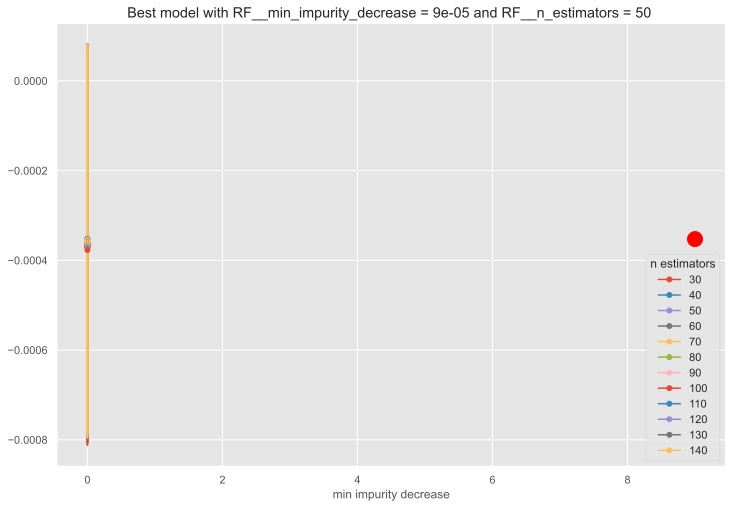

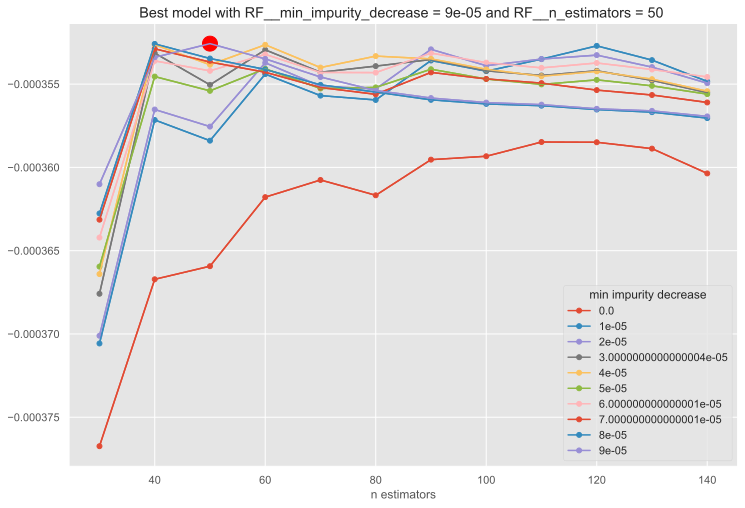

In [51]:
MT.plotModelGridError(rf_fit)

In [52]:
# Predictions
dfTR_eval['RF_pred'] = rf_fit.predict(x_train)
dfV_eval['RF_pred'] = rf_fit.predict(x_valid)

In [53]:
# Calculate metrics for training set
train_rmse, train_mse, train_mae = calculate_metrics(y_train, dfTR_eval['RF_pred'])

# Calculate metrics for validation set
valid_rmse, valid_mse, valid_mae = calculate_metrics(y_valid, dfV_eval['RF_pred'])

In [54]:
print("Training Metrics:")
print("RMSE:", train_rmse)
print("MSE:", train_mse)
print("MAE:", train_mae)

print("\nValidation Metrics:")
print("RMSE:", valid_rmse)
print("MSE:", valid_mse)
print("MAE:", valid_mae)

Training Metrics:
RMSE: 0.017857769630138045
MSE: 0.00031889993616308063
MAE: 0.005027383303643548

Validation Metrics:
RMSE: 0.010497640935700494
MSE: 0.00011020046521489473
MAE: 0.004193329567657026


As we can see, models that uses CV and hyperparameter optimization are much better, improving its ability to predict and generalize. Specially, random forests is one of the best methods for ML prediction, so its good results are not something to be surprised. It is important to bear in mind that our response variable moves between 0-1, so a RMSE of 0.0178577 it is equivalent to a RMSE near 1.8 in a vector with a maximum of 100 (but most of them below 10, so the results are not as good as it seems).

After this basic methods, some simple neural networks are tested. It will be used a DenseNet, a RNN and a LSTM/GRU, before entering deeper neural networks and pretrained models.

#### Deep learning custom models

In [55]:
# Convert Pandas DataFrames to NumPy arrays
x_train_array = x_train.values
y_train_array = y_train.values

x_valid_array = x_valid.values
y_valid_array = y_valid.values

**DENSENET**

In [114]:
# Define the model architecture
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(2436,)))  # Assuming each row represents a sentence embedding
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='linear')) # Linear activation for regression

In [115]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error,  # Using mean squared error loss for regression
              metrics=[metrics.mean_squared_error])  # Mean squared error metric

In [116]:
# Train the model
history = model.fit(x_train_array,
                    y_train_array,  
                    epochs=50, batch_size=16, 
                    validation_data=(x_valid_array, y_valid_array))

Epoch 1/50


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6971e-04 - mean_squared_error: 6.6971e-04 - val_loss: 1.4112e-04 - val_mean_squared_error: 1.4112e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7157e-04 - mean_squared_error: 1.7157e-04 - val_loss: 1.6222e-04 - val_mean_squared_error: 1.6222e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0361e-04 - mean_squared_error: 2.0361e-04 - val_loss: 1.4780e-04 - val_mean_squared_error: 1.4780e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4691e-04 - mean_squared_error: 1.4691e-04 - val_loss: 1.6902e-04 - val_mean_squared_error: 1.6902e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5646e-04 - mean_squared_error: 2.5646e-04 - val_loss: 1.4921e-04 - val_mean_squared_error: 1.4921e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3348e-04 - mean_squared_error: 1.3348e-04 - val_loss: 1.6091e-04 - val_mean_squared_error: 1.6091e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0

In [117]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

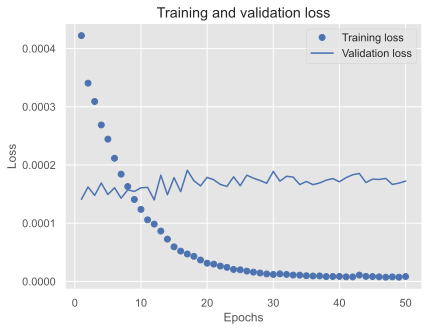

In [118]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

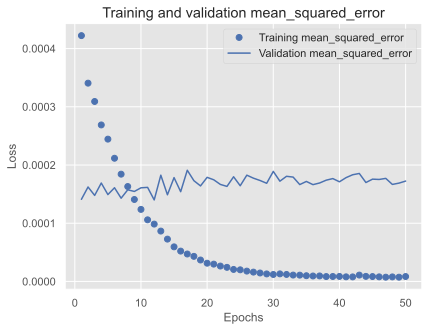

In [119]:
plt.clf()   # clear figure
acc_values = history_dict['mean_squared_error']
val_acc_values = history_dict['val_mean_squared_error']

plt.plot(epochs, acc, 'bo', label='Training mean_squared_error')
plt.plot(epochs, val_acc, 'b', label='Validation mean_squared_error')
plt.title('Training and validation mean_squared_error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on test data
valid_loss, valid_mse = model.evaluate(x_valid_array, y_valid_array)

print("Test Loss:", valid_loss)
print("Test Mean Squared Error:", valid_mse)

From these results two conclusions can be drawn:

 + The first one is that this simple densenet model has a slightly higher test MSE than Random Forest, so it may indicate that there is not enough information in the text to require a complex model.

 + On the other hand, the test error seems to remain constant, something that is not recommended since, therefore, the model adjusts only to the training data with clear symptoms of overfitting. This could also be for several reasons:

    + It is needed a more complex neural network (it is going to be tested afterwards).

    + There is not so much information in the text and it is not possible to be more precise without more information (audio and video), having a MSE barrier that it is not possible for us to surpass.

    + There is something wrong with the model of data.



The main reason seems to be the second one of the second statement, but the study will keep on with a RNN and a LSTM.

**RNN**

In [126]:
x_train_array

array([[ 0.04192333, -0.00749691, -0.00406863, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00378   ,  0.02695082,  0.02691954, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04192337, -0.00749691, -0.00406863, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00593488,  0.00702702, -0.01444855, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0082139 ,  0.01800829,  0.0116427 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03924031,  0.0126305 , -0.0080342 , ...,  0.        ,
         0.        ,  0.        ]])

In [131]:
model = models.Sequential()
model.add(layers.SimpleRNN(128, input_shape=(None, 2436), return_sequences=True))
model.add(layers.SimpleRNN(64, return_sequences=True))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_15 (SimpleRNN)       │ (None, None, 128)      │       328,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, None, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,809 (1.31 MB)

 Trainable params: 343,809 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [134]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error,  # Using mean squared error loss for regression
              metrics=[metrics.mean_squared_error])  # Mean squared error metric

In [132]:
# Expandir la dimensión de la entrada
x_train_rnn = np.expand_dims(x_train, axis=1)
x_valid_rnn = np.expand_dims(x_valid, axis=1)

In [135]:
# Train the model
history = model.fit(x_train_rnn,
                    y_train,  
                    epochs=100, batch_size=16, 
                    validation_data=(x_valid_rnn, y_valid))

Epoch 1/100


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1269 - mean_squared_error: 0.1269 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 8.1133e-04 - val_mean_squared_error: 8.1133e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9913e-04 - mean_squared_error: 8.9913e-04 - val_loss: 6.3150e-04 - val_mean_squared_error: 6.3150e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9103e-04 - mean_squared_error: 7.9103e-04 - v

In [136]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

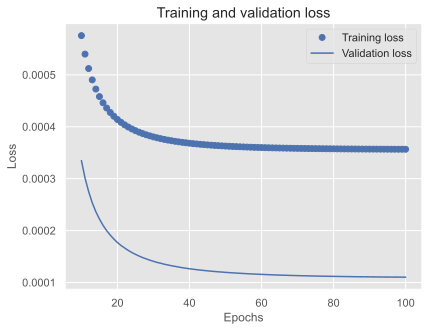

In [145]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(10, len(acc) + 1) # It starts on 10 to see in more detail the majority of epochs

# "bo" is for "blue dot"
plt.plot(epochs, loss[epochs[0]-1:], 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss[epochs[0]-1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

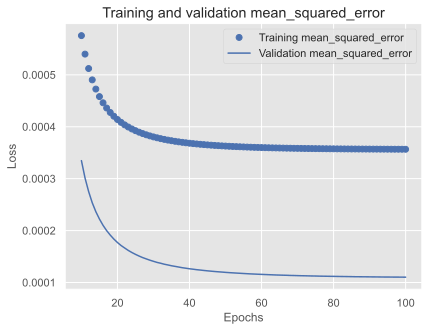

In [146]:
plt.clf()   # clear figure
acc_values = history_dict['mean_squared_error']
val_acc_values = history_dict['val_mean_squared_error']

plt.plot(epochs, acc[epochs[0]-1:], 'bo', label='Training mean_squared_error')
plt.plot(epochs, val_acc[epochs[0]-1:], 'b', label='Validation mean_squared_error')
plt.title('Training and validation mean_squared_error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [148]:
# Evaluate the model on test data
valid_loss, valid_mse = model.evaluate(x_valid_rnn, y_valid)

print("Test Loss:", valid_loss)
print("Test Mean Squared Error:", valid_mse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5919e-04 - mean_squared_error: 1.5919e-04 
Test Loss: 0.0001102384485420771
Test Mean Squared Error: 0.0001102384485420771


As it could be easily seen, this model is much better than the previous one. It does not have any sign of overfitting, with near the same values for training and testing. Furthermore, the test MSE is much lower, near the Random Forest one, but the ensemble method tended to overfit, so it seems to be the best model (even tough the improvement has been slight). 

**LSTM**

In [ ]:
### Load libraries ###

# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer

from sklearn import set_config
set_config(display='diagram')

# others
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mltools import regression_tools as RT
from mltools.regression_tools import LinearRegressor
from mltools import model_tools as MT